In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Load the datasets
channel_spend = pd.read_csv('Creditor(watch) - Channel Spend By Month.csv')
leads = pd.read_csv('Creditor(watch) - Leads (2).csv')
sales = pd.read_csv('Creditor(watch) - Sales.csv')

Cleaning and Transforming Channel_Soend Dataset

In [18]:
# Clean the channel spend data
channel_spend = channel_spend.replace({'\$': '', ',': '', '-': '0'}, regex=True)
for col in channel_spend.columns[1:]:
    channel_spend[col] = pd.to_numeric(channel_spend[col].astype(str).str.strip())

# Add the year to the month and convert to datetime
channel_spend_melted = channel_spend.melt(id_vars=["Channel"], var_name="Month", value_name="Spend")
channel_spend_melted['Month'] = pd.to_datetime(channel_spend_melted['Month'] + '-2023', format='%d-%b-%Y')

channel_spend_melted.head()

,Channel,Month,Spend
0,Social,2023-01-01,1000
1,Paid Search,2023-01-01,5000
2,Display,2023-01-01,2500
3,Event,2023-01-01,0
4,Social,2023-02-01,1000


Cleaning and Transforming Leads and Sales Data

In [19]:
# Clean leads and sales data
leads['Date'] = pd.to_datetime(leads['Date'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
leads['Month'] = pd.to_datetime(leads['Month'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
sales['Date'] = pd.to_datetime(sales['Date'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
sales['Month'] = pd.to_datetime(sales['Month'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
sales['Sale Amount'] = sales['Sale Amount'].replace({'\$': '', ',': ''}, regex=True).astype(float)


In [21]:
# Merge leads and sales data to attribute sales to channels
merged_data = leads.merge(sales, on=['Company ID', 'Month'], suffixes=('_lead', '_sale'))

# Distribute sales amount evenly across all leads for each company
merged_data['Sale Amount'] = merged_data['Sale Amount'] / merged_data.groupby('Company ID')['Company ID'].transform('count')


Cumulative Metrics

In [22]:
# Aggregate total spend per channel
total_spend_per_channel = channel_spend_melted.groupby('Channel')['Spend'].sum().reset_index()

# Aggregate total leads per channel
total_leads_per_channel = leads.groupby('Channel').size().reset_index(name='Total Leads')

# Aggregate total revenue per channel after distributing sales amount
total_revenue_per_channel = merged_data.groupby('Channel')['Sale Amount'].sum().reset_index()
total_revenue_per_channel.columns = ['Channel', 'Total Revenue']

# Aggregate total sales per channel after distributing sales amount
total_sales_per_channel = merged_data.groupby('Channel')['Sale Amount'].count().reset_index()
total_sales_per_channel.columns = ['Channel', 'Total Sales']


In [23]:
# Calculate CPL
cpl = total_spend_per_channel.merge(total_leads_per_channel, on='Channel')
cpl['CPL'] = cpl['Spend'] / cpl['Total Leads']

# Calculate CPA
cpa = total_spend_per_channel.merge(total_sales_per_channel, on='Channel')
cpa['CPA'] = cpa['Spend'] / cpa['Total Sales']

# Calculate ROI
roi = total_spend_per_channel.merge(total_revenue_per_channel, on='Channel')
roi['ROI'] = (roi['Total Revenue'] - roi['Spend']) / roi['Spend']


In [24]:
cpl.head()

,Channel,Spend,Total Leads,CPL
0,Display,30000,60,500.000000
1,Event,60000,149,402.684564
2,Paid Search,90000,75,1200.000000
3,Social,12000,74,162.162162


Visualisation 

In [25]:
palette = {
    "Social": "#3399cc",
    "Paid Search": "#ffa64d",
    "Display": "#4db84d",
    "Event": "#ff4d4d"
}



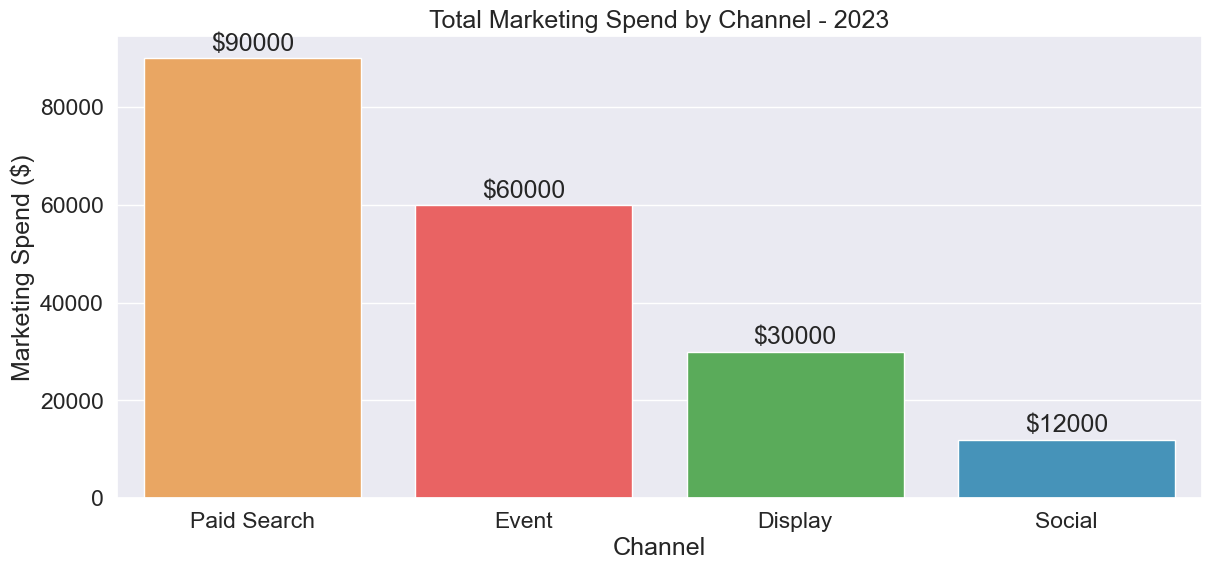

In [26]:
# Adjusting the approach to display the numbers on each bar
sns.set(font_scale=1.5)

plt.figure(figsize=(14, 6))
data_sorted = total_spend_per_channel.sort_values(by='Spend', ascending=False)
barplot = sns.barplot(data=data_sorted, x='Channel', y='Spend', palette=palette)
plt.title('Total Marketing Spend by Channel - 2023') # 2023 - Annual 
plt.xlabel('Channel')
plt.ylabel('Marketing Spend ($)')

# Display numbers on each bar
for p in barplot.patches:
    barplot.annotate(f"${p.get_height():.0f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10),
                     textcoords='offset points')

plt.show()


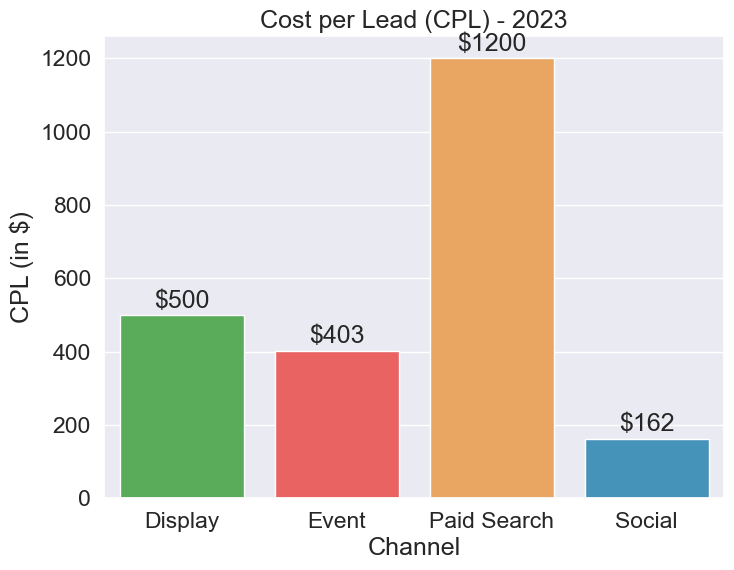

In [31]:
# CPL per Channel with modifications
sns.set(font_scale=1.5)

plt.figure(figsize=(8, 6))
#data_sorted_cpl = cpl.sort_values(by='CPL', ascending=False)
barplot = sns.barplot(data=cpl, x='Channel', y='CPL', palette=palette)
plt.title('Cost per Lead (CPL) - 2023')
plt.xlabel('Channel')
plt.ylabel('CPL (in $)')

# Display numbers on each bar
for p in barplot.patches:
    barplot.annotate(f"${p.get_height():.0f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10),
                     textcoords='offset points')

plt.show()


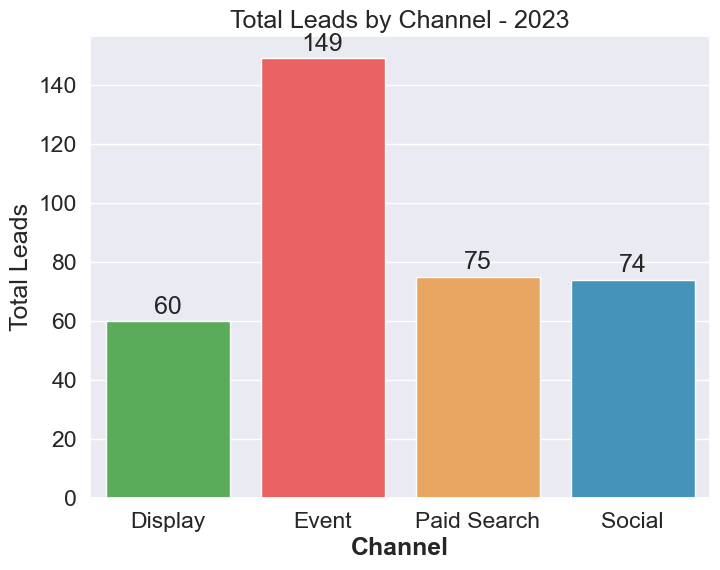

In [32]:
# Total Leads per Channel with modifications
sns.set(font_scale=1.5)

plt.figure(figsize=(8, 6))
#data_sorted_leads = total_leads_per_channel.sort_values(by='Total Leads', ascending=False)
barplot = sns.barplot(data=total_leads_per_channel, x='Channel', y='Total Leads', palette=palette)
plt.title('Total Leads by Channel - 2023')
plt.xlabel('Channel',weight="bold")
plt.ylabel('Total Leads')

# Display numbers on each bar
for p in barplot.patches:
    barplot.annotate(f"{p.get_height():.0f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10),
                     textcoords='offset points')

plt.show()


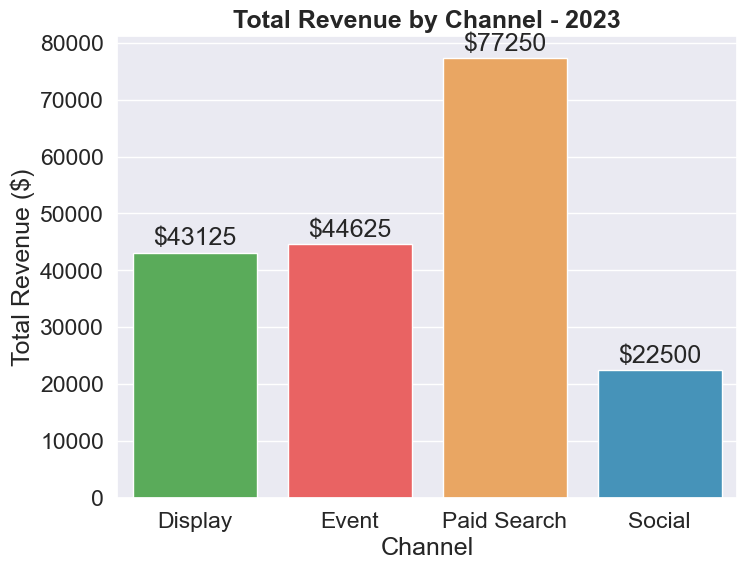

In [33]:
# Total Revenue per Channel with modifications
sns.set(font_scale=1.5)

plt.figure(figsize=(8, 6))
#data_sorted_revenue = roi.sort_values(by='Total Revenue', ascending=False)
barplot = sns.barplot(data=roi, x='Channel', y='Total Revenue', palette=palette)
plt.title('Total Revenue by Channel - 2023',weight="bold")
plt.xlabel('Channel')
plt.ylabel('Total Revenue ($)')

# Display numbers on each bar
for p in barplot.patches:
    barplot.annotate(f"${p.get_height():.0f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10),
                     textcoords='offset points')

plt.show()

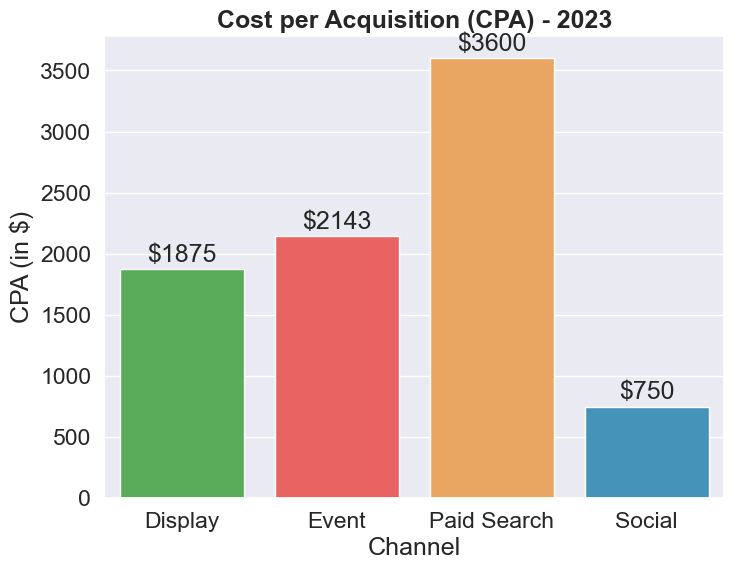

In [34]:
# CPA per Channel with modifications
sns.set(font_scale=1.5)

plt.figure(figsize=(8, 6))
#data_sorted_cpa = cpa.sort_values(by='CPA', ascending=False)
barplot = sns.barplot(data=cpa, x='Channel', y='CPA', palette=palette)
plt.title('Cost per Acquisition (CPA) - 2023',weight='bold')
plt.xlabel('Channel')
plt.ylabel('CPA (in $)')

# Display numbers on each bar
for p in barplot.patches:
    barplot.annotate(f"${p.get_height():.0f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 10),
                     textcoords='offset points')

plt.show()

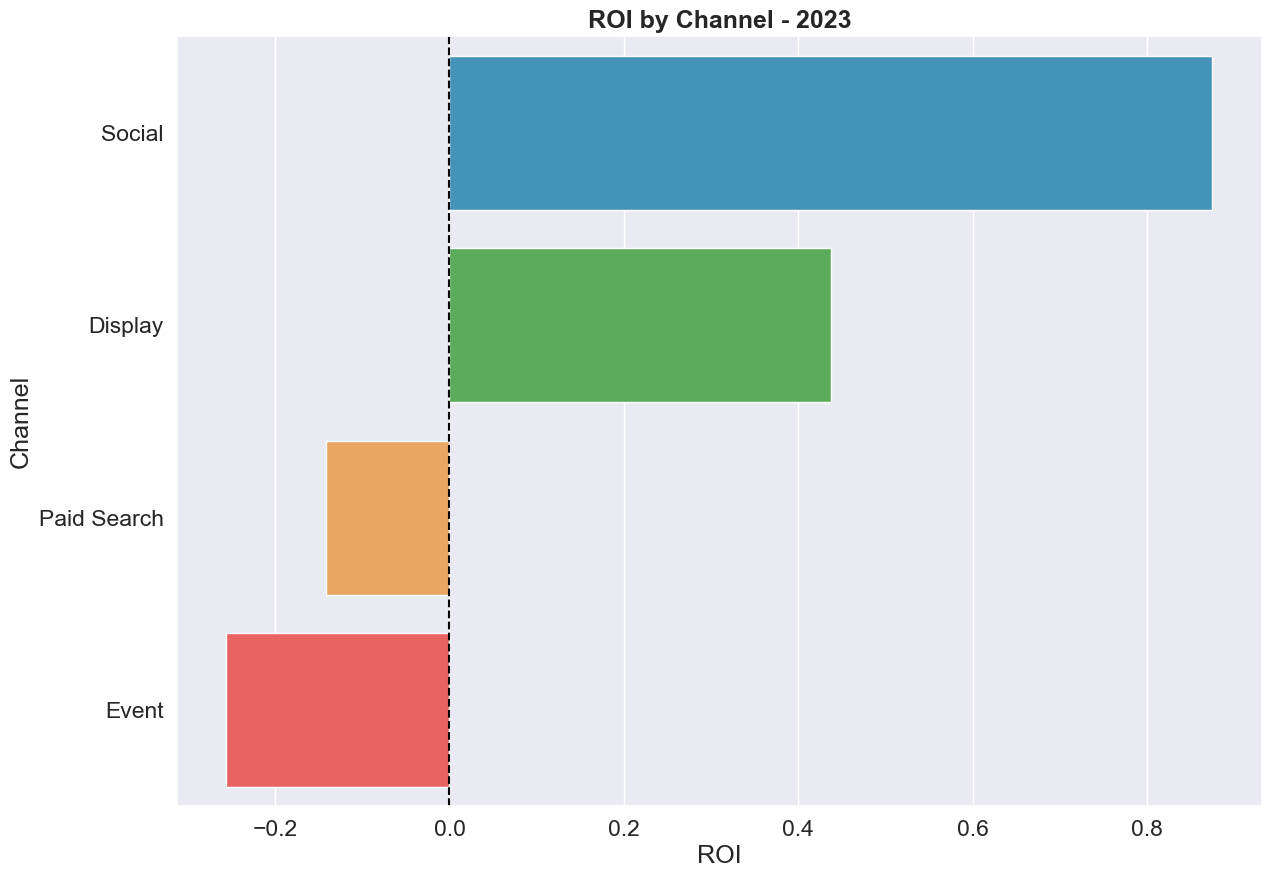

In [35]:

sns.set(font_scale=1.5)

plt.figure(figsize=(14, 10))  # Adjusted figsize for better vertical display
data_sorted_roi = roi.sort_values(by='ROI', ascending=False)
barplot = sns.barplot(data=data_sorted_roi, y='Channel', x='ROI', palette=palette)
plt.axvline(0, color='black', linestyle='--')  # Add a horizontal line at y=0 to indicate 0 ROI
plt.title('ROI by Channel - 2023',weight='bold')
plt.xlabel('ROI')
plt.ylabel('Channel')


plt.show()
